## Importing Libraries

In [ ]:
!pip install datasets
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
!pip install spacy
!pip install gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Loading Necessary Libraries
import datasets # Importing Hugging face data
import pandas as pd # Importing pandas Library
from google.colab import data_table # Systemized way of displaying data
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import spacy
from collections import defaultdict, Counter

## Data Collection

In [ ]:
data_table.enable_dataframe_formatter() # More systemized way of displaying data

In [ ]:
df = datasets.load_dataset("yelp_polarity") # Loading the data from hugging face datasets

In [ ]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38000
    })
})

In [ ]:
train_df = df["train"] # Loading split part of data (train part)
train_df = pd.DataFrame(train_df) # Converting into dataframe
train_df = train_df.iloc[:100000, :]
train_df.head() # Displaying the first 5 rows of train data

,text,label
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1


In [ ]:
test_df = df["test"] # Loading split part of data (test part)
test_df = pd.DataFrame(test_df) # Converting the data into a dataframe
test_df = test_df.iloc[:10000, :] # Selecting less rows for hardware complexity barrier
test_df.head() # Displaying first 5 rows of test data

,text,label
0,"Contrary to other reviews, I have zero complai...",1
1,Last summer I had an appointment to get new ti...,0
2,"Friendly staff, same starbucks fair you get an...",1
3,The food is good. Unfortunately the service is...,0
4,Even when we didn't have a car Filene's Baseme...,1


## Analysis

### Data Preprocessing and Transformation

In [ ]:
train_df["label"].value_counts()

0    53197
1    46803
Name: label, dtype: int64

In [ ]:
test_df["label"].value_counts()

0    5367
1    4633
Name: label, dtype: int64

Here it is clear that dict_keys Labels are split as:
([(0, 0.0), (0, 1.0), (1, 3.0), (1, 4.0)]).

Therefore there are only two labels in the dataset, positive and negative
* 0 - Negative
* 1 - Positive

In [ ]:
train_df.info() # Checking for Null Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    100000 non-null  object
 1   label   100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [ ]:
test_df.info() # Checking for Null Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
maxlen = train_df['text'].apply(lambda x: len(x.split())).max()

def preprocess_text(text):
    text = text.lower()  # Converting to lowercase

    for punctuation in string.punctuation: # Removing punctuation symbols
        text = text.replace(punctuation, ' ')

    for digit in string.digits: # Removing numbers (digits)
        text = text.replace(digit, ' ')

    stop = set(stopwords.words('english')) # Removing stopwords
    words = text.split()
    words = [word for word in words if word not in stop]

    lemmatizer = WordNetLemmatizer() # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    processed_text = ' '.join(words) # Joining words back into a single string

    return processed_text

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [ ]:
train_df.head()

,text,label
0,unfortunately frustration dr goldberg patient ...,0
1,going dr goldberg year think one st patient st...,1
2,know dr goldberg like moving arizona let tell ...,0
3,writing review give head see doctor office sta...,0
4,food great best thing wing wing simply fantast...,1


In [ ]:
test_df.head()

,text,label
0,contrary review zero complaint service price g...,1
1,last summer appointment get new tire wait supe...,0
2,friendly staff starbucks fair get anywhere els...,1
3,food good unfortunately service hit miss main ...,0
4,even car filene basement worth bus trip waterf...,1


In [ ]:
train_explore = train_df.copy()
test_explore = test_df.copy()

In [ ]:
vocab_size = 10000
embed_size = 32

tok = Tokenizer(num_words = vocab_size) # Creating and Fitting tokenizer
tok.fit_on_texts(train_df['text'])
tok.fit_on_texts(test_df['text'])

train_df['text'] = tok.texts_to_sequences(train_df['text']) # Tokenizing data
test_df['text'] = tok.texts_to_sequences(test_df['text'])

In [ ]:
train_df.head()

,text,label
0,"[575, 3234, 421, 788, 1760, 57, 107, 507, 2483...",0
1,"[37, 421, 44, 65, 8, 887, 788, 309, 13, 44, 14...",1
2,"[26, 421, 6, 1091, 733, 147, 159, 235, 131, 50...",0
3,"[1328, 90, 74, 488, 81, 507, 313, 49, 1228, 12...",0
4,"[3, 13, 43, 40, 368, 368, 669, 480, 1710, 2461...",1


In [ ]:
test_df.head()

,text,label
0,"[6784, 90, 1074, 602, 9, 39, 178, 591, 9, 365,...",1
1,"[94, 951, 394, 7, 83, 591, 86, 258, 108, 5, 22...",0
2,"[85, 49, 1152, 781, 7, 674, 153, 521, 194, 7, ...",1
3,"[3, 4, 575, 9, 530, 686, 608, 323, 349, 436, 2...",0
4,"[16, 100, 4213, 166, 1144, 420, 7006, 32, 92, ...",1


In [ ]:
# Padding data
train_df['text'] = train_df['text'].apply(lambda x: pad_sequences([x], maxlen=maxlen)[0])
test_df['text'] = test_df['text'].apply(lambda x: pad_sequences([x], maxlen=maxlen)[0])

In [ ]:
train_df.head()

,text,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [ ]:
test_df.head()

,text,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


### Exploratory Data Analysis

In [ ]:
# In this section I have created two list for extracting the positive(1) and negative reviews(0)
positive=[]
negative=[]
positive_reviews = train_explore[train_explore['label']==1]['text']
negative_reviews = train_explore[train_explore['label']==0]['text']

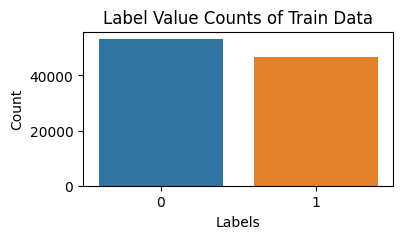

In [ ]:
plt.figure(figsize=(4, 2))
sns.countplot(data = train_explore, x='label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Value Counts of Train Data')
plt.show()

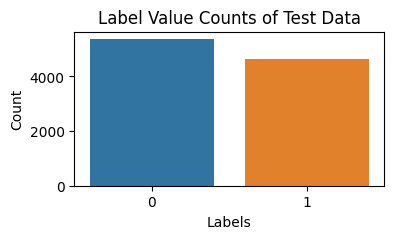

In [ ]:
plt.figure(figsize=(4, 2))
sns.countplot(data = test_explore, x='label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Value Counts of Test Data')
plt.show()

In [ ]:
positive_reviews.shape, negative_reviews.shape

((46803,), (53197,))

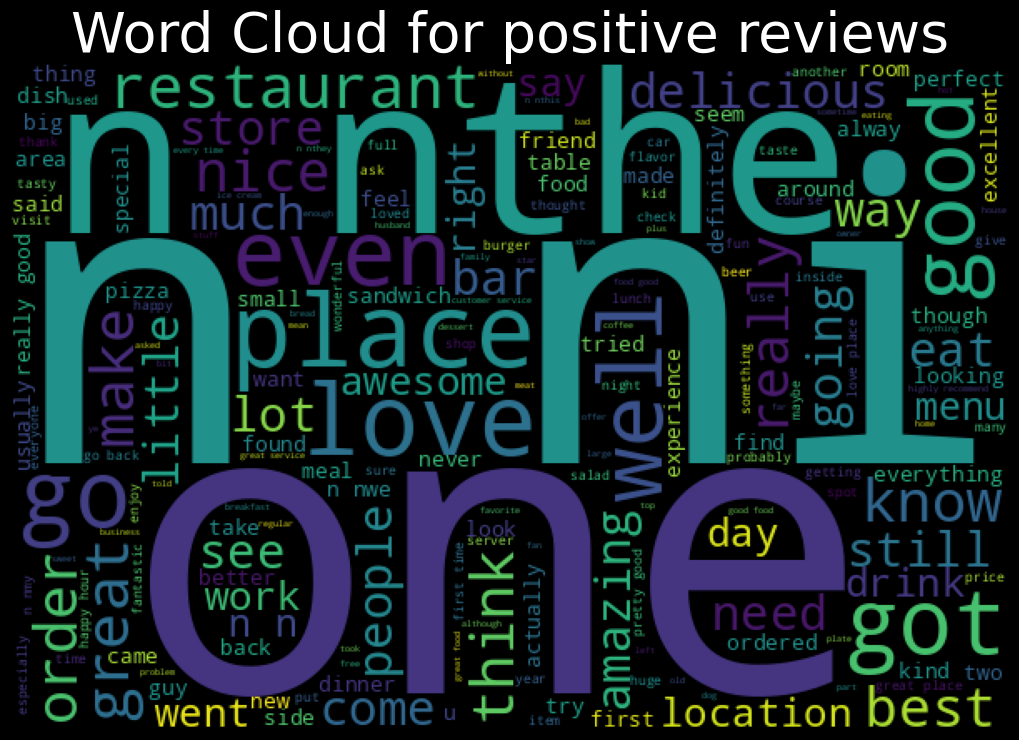

In [ ]:
pos_review_cloud=WordCloud(width=600,height=400).generate(" ".join(positive_reviews))
plt.figure(figsize=(10,8),facecolor='k')
plt.title("Word Cloud for positive reviews", fontsize=40, color = "white")
plt.imshow(pos_review_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

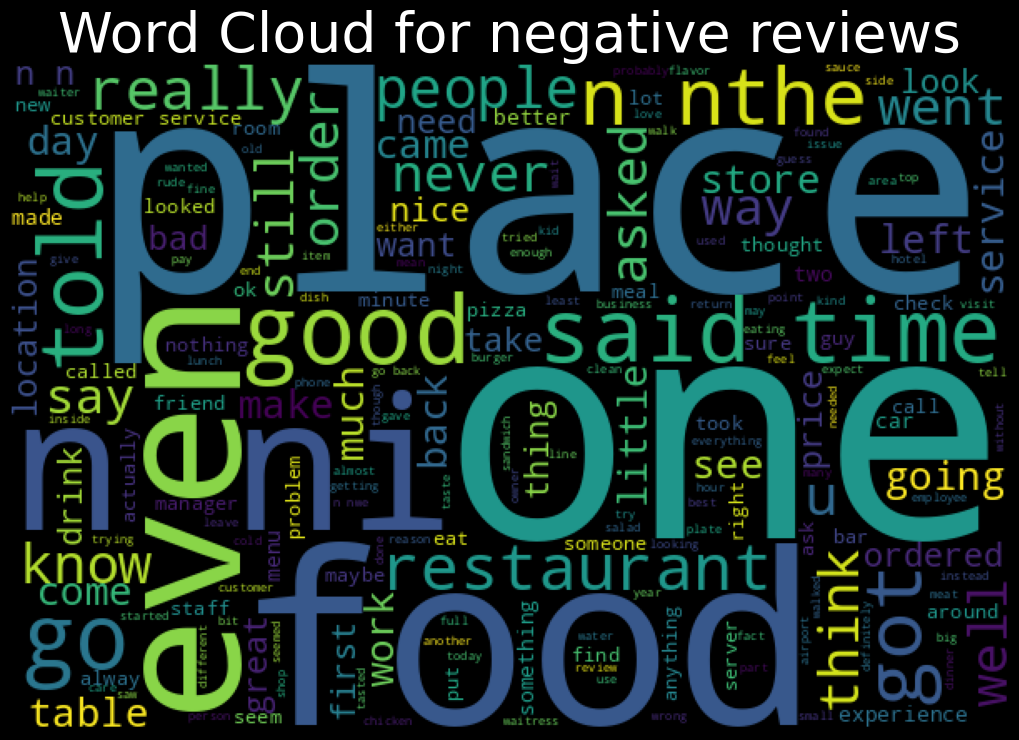

In [ ]:
neg_review_cloud=WordCloud(width=600,height=400,background_color='black').generate(" ".join(negative_reviews[:15000])) # Using only the first 15000 rows because of hardware complexity barrier
plt.figure(figsize=(10,8),facecolor='k')
plt.title("Word Cloud for negative reviews", fontsize=40, color = "white")
plt.imshow(neg_review_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
def extract_words(text):
    return re.findall(r'\w+', text.lower())

In [ ]:
all_positive_reviews_text = " ".join(positive_reviews) # Combining all positive reviews into a single string

words = extract_words(all_positive_reviews_text) # Extracting words from the combined text

positive_word_counts = Counter(words) # Counting frequency of each word

top_10_positive_words = positive_word_counts.most_common(10)  # Getting top 10 most frequent positive words

for word, count in top_10_positive_words: # Printing top 10 positive words
    print(f"{word}: {count} times")

n: 58486 times
place: 29751 times
good: 27560 times
great: 25628 times
food: 23766 times
time: 18640 times
like: 17743 times
get: 17144 times
one: 15855 times
go: 14829 times


In [ ]:
all_negative_reviews_text = " ".join(negative_reviews) # Combining all positive reviews into a single string

words = extract_words(all_negative_reviews_text) # Extracting words from the combined text

negative_word_counts = Counter(words) # Counting frequency of each word

top_10_negative_words = negative_word_counts.most_common(10) # Getting top 10 most frequent positive words

for word, count in top_10_negative_words: # Printing top 10 positive words
    print(f"{word}: {count} times")

n: 78500 times
food: 33986 times
place: 32806 times
time: 30779 times
like: 28184 times
one: 27290 times
get: 27202 times
would: 26606 times
service: 23793 times
back: 23647 times


In [ ]:
train_explore_1 = train_explore.copy()
test_explore_1 = test_explore.copy()

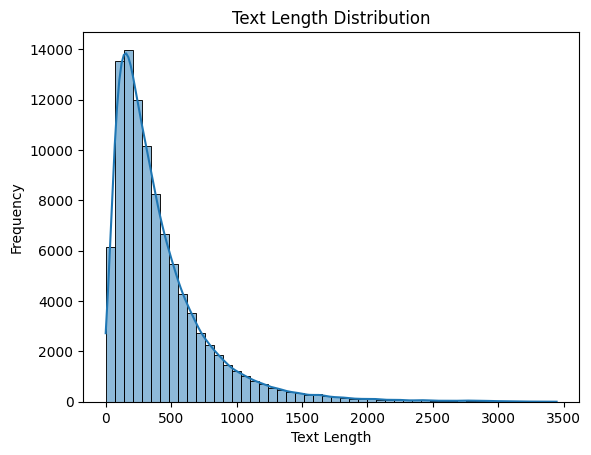

In [ ]:
# Text Length Histogram
train_explore_1['text_length'] = train_explore_1['text'].apply(len)
sns.histplot(data=train_explore_1, x='text_length', kde=True, bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
train_explore_1 = train_explore_1.drop('text_length', axis=1)

In [ ]:
sentences = [text.split() for text in train_explore_1['text']] # Creating a list of sentences from your preprocessed text data

model_word2vec = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0) # Training Word2Vec model

In [ ]:
similar_words = model_word2vec.wv.most_similar("love") # Finding word similarities
print("Words similar to 'love':")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

Words similar to 'love':
loved: 0.7143968343734741
amazing: 0.639860212802887
awesome: 0.6185078024864197
crave: 0.6082401275634766
fantastic: 0.5942226052284241
enjoy: 0.5717735886573792
great: 0.5711877942085266
adore: 0.54939204454422
wonderful: 0.5489953756332397
lover: 0.5452772974967957


In [ ]:
similar_words = model_word2vec.wv.most_similar("never") # Finding word similarities
print("Words similar to 'never':")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

Words similar to 'never':
ever: 0.5393962860107422
rarely: 0.5210022330284119
twice: 0.4750332534313202
nobody: 0.4685843884944916
multiple: 0.4576776623725891
wont: 0.4564953148365021
rhine: 0.45559316873550415
instillation: 0.44770532846450806
didnt: 0.4402315318584442
yet: 0.4205934703350067


In [ ]:
word_relationship = model_word2vec.wv.most_similar(positive=["amazing", "best"], negative=["never"])  # Finding word relationships
print("Relationship between positive and negative:")
for word, similarity in word_relationship:
    print(f"{word}: {similarity}")

Relationship between positive and negative:
fantastic: 0.7258995175361633
phenomenal: 0.6946977972984314
incredible: 0.6891438364982605
awesome: 0.6705282330513
fabulous: 0.6359105110168457
excellent: 0.6347067356109619
terrific: 0.6327843070030212
greatest: 0.6278409361839294
wonderful: 0.6128358840942383
delicious: 0.6010649800300598


Named Entity Recognition (NER) Analysis

In [ ]:
nlp = spacy.load('en_core_web_sm')  # Loading spaCy model

def extract_named_entities(text_column):
    """
    Extract named entities from a list of text documents and return the top entities for each label.

    :param text_column: List of text documents
    :return: Dictionary containing the top entities for each label
    """
    docs = list(nlp.pipe(text_column))  # Processing each document in text_column

    named_entities = defaultdict(list) # Initializing dictionaries to store named entities and their counts
    entity_counts = defaultdict(Counter)

    for doc in docs:  # Iterating through processed documents
        for ent in doc.ents:  # Extracting named entities in each document
            named_entities[ent.label_].append(ent.text)
            entity_counts[ent.label_][ent.text] += 1

    top_entities = {}  # Extracting top entities for each label based on their counts
    for label, counts in entity_counts.items():
        top_entities[label] = [entity for entity, count in counts.most_common(75)]

    return top_entities

In [ ]:
text_column = train_explore_1["text"][:15000] # For the top entities for train data
top_entities = extract_named_entities(text_column)

In [ ]:
for label, entities in top_entities.items():  # Printing top entities for each label
    print(f"{label}: {entities}")

PERSON: ['madison', 'patty', 'strawberry', 'joe', 'mike', 'max', 'dessert', 'matt', 'morton', 'ruth chris', 'michael', 'mac n', 'lo mein', 'alice cooper', 'chang', 'sam', 'tim', 'pizzeria bianco', 'del taco', 'squirrel hill', 'david', 'kinda', 'chris', 'tomato basil', 'sushi kim', 'yuck', 'penn mac', 'carl', 'george dragon', 'jack', 'mac cheese', 'tom', 'jeff', 'williams', 'charlotte douglas', 'urbana', 'johnson', 'bush', 'barr', 'john', 'ben', 'kim', 'bagel', 'kevin', 'merry ann', 'chuck', 'yummy', 'burgh', 'al dente', 'rick', 'pad thai', 'wendy', 'miguel', 'kamakura', 'dave', 'basil', 'larry', 'pamela', 'bianco', 'al', 'linda', 'melt mouth', 'monica', 'cafe sam', 'paul', 'lunch buffet', 'mardi gras', 'sun', 'mac', 'dick arnie', 'robert', 'da burgh', 'murphy', 'mayo', 'groomsman']
TIME: ['night', 'hour', 'evening', 'minute', 'last night', 'morning', 'afternoon', 'tonight', 'another minute', 'late night', 'ten minute', 'one night', 'half hour', 'five minute', 'two hour', 'noon', 'last 

In [ ]:
train_explore_1['words_count'] = train_explore_1['text'].apply(lambda x: len(x.split()))
test_explore_1['words_count'] = test_explore_1['text'].apply(lambda x: len(x.split()))

In [ ]:
train_explore_1['character_count'] = train_explore_1['text'].apply(len)
test_explore_1['character_count'] = test_explore_1['text'].apply(len)

In [ ]:
train_explore_1['average_word_length'] = train_explore_1['character_count'] / train_explore_1['words_count']
test_explore_1['average_word_length'] = test_explore_1['character_count'] / test_explore_1['words_count']

In [ ]:
train_explore_1.head()

,text,label,words_count,character_count,average_word_length
0,unfortunately frustration dr goldberg patient ...,0,52,359,6.903846
1,going dr goldberg year think one st patient st...,1,38,243,6.394737
2,know dr goldberg like moving arizona let tell ...,0,99,639,6.454545
3,writing review give head see doctor office sta...,0,94,636,6.765957
4,food great best thing wing wing simply fantast...,1,44,258,5.863636


In [ ]:
test_explore_1.head()

,text,label,words_count,character_count,average_word_length
0,contrary review zero complaint service price g...,1,54,365,6.759259
1,last summer appointment get new tire wait supe...,0,34,212,6.235294
2,friendly staff starbucks fair get anywhere els...,1,11,71,6.454545
3,food good unfortunately service hit miss main ...,0,26,180,6.923077
4,even car filene basement worth bus trip waterf...,1,77,509,6.610390


In [ ]:
correlation_matrix = train_explore_1.corr()
correlation_with_label = correlation_matrix['label'].sort_values(ascending=False)
correlation_with_label

# Correlation between these columns is very less, hence cannot be considered

<ipython-input-95-2ba4d71f7a86>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_explore_1.corr()


label                  1.000000
average_word_length    0.023168
character_count       -0.145032
words_count           -0.146111
Name: label, dtype: float64

<ipython-input-96-5f61d30a323e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_explore_1.corr()


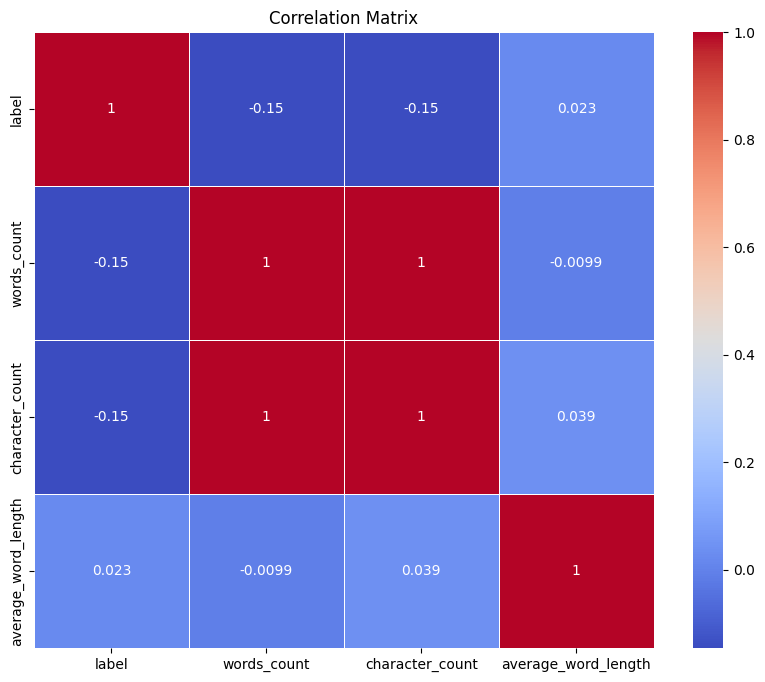

In [ ]:
correlation_matrix = train_explore_1.corr()

plt.figure(figsize=(10, 8)) # PLotting a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

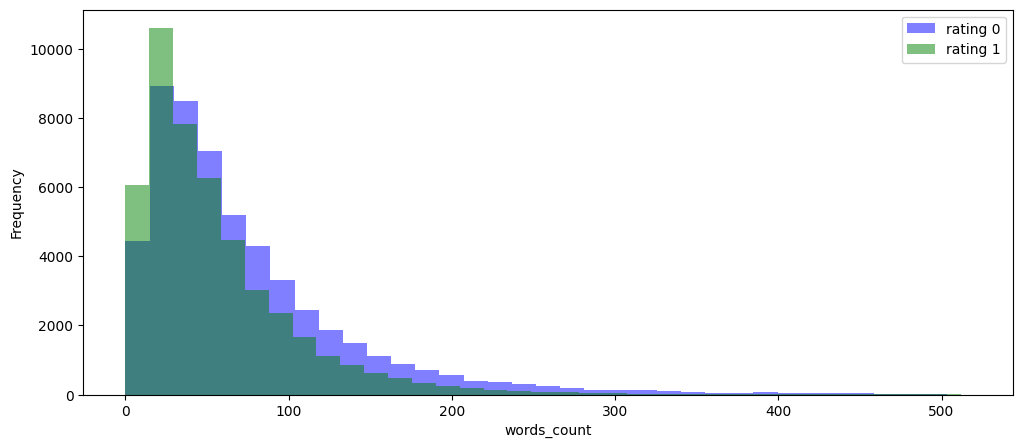

In [ ]:
plt.figure(figsize=(12, 5))

train_explore_1[train_explore_1['label'] == 0]['words_count'].plot(bins=35, alpha=0.5, kind='hist', color='blue', label='rating 0') # Plotting histogram for 'label' 0 in blue

train_explore_1[train_explore_1['label'] == 1]['words_count'].plot(bins=35, alpha=0.5, kind='hist', color='green', label='rating 1') # Plotting the histogram for 'label' 1 in green

plt.legend()
plt.xlabel('words_count')
plt.show()

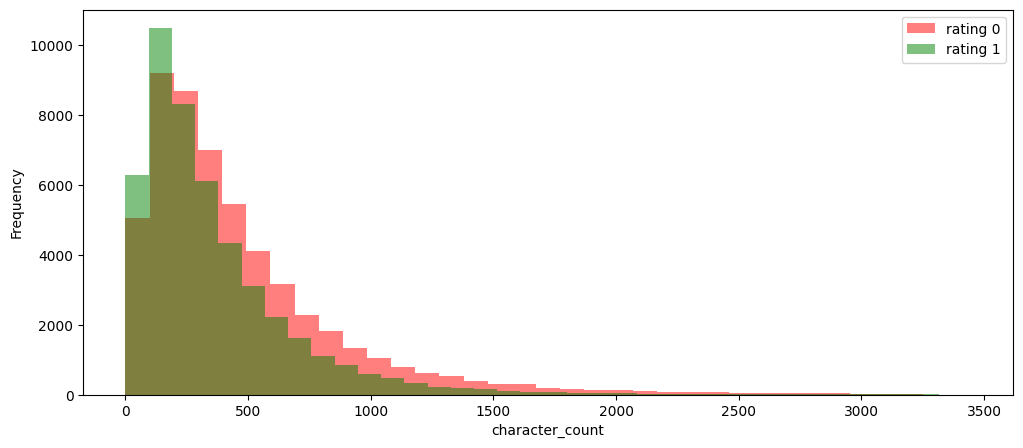

In [ ]:
plt.figure(figsize=(12, 5))

train_explore_1[train_explore_1['label'] == 0]['character_count'].plot(bins=35, alpha=0.5, kind='hist', color='red', label='rating 0') # Plotting histogram for 'label' 0 in red

train_explore_1[train_explore_1['label'] == 1]['character_count'].plot(bins=35, alpha=0.5, kind='hist', color='green', label='rating 1') # Plotting histogram for 'label' 1 in green

plt.legend()
plt.xlabel('character_count')
plt.show()

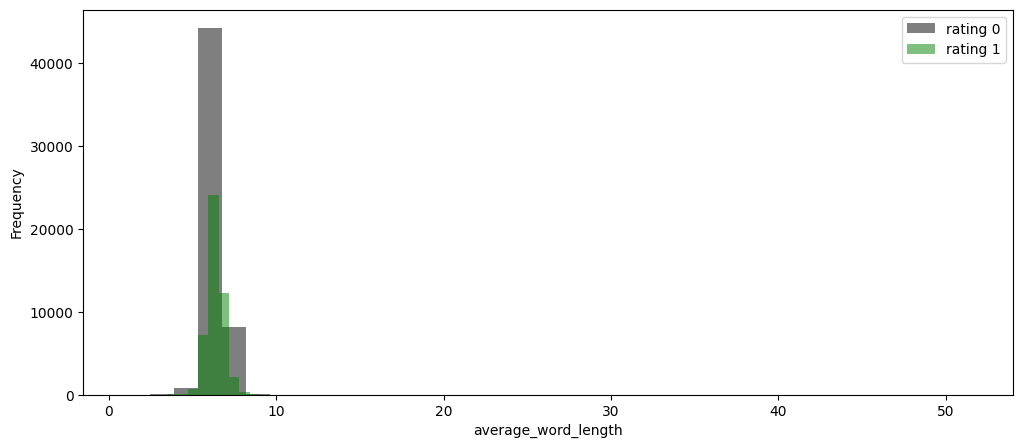

In [ ]:
plt.figure(figsize=(12, 5))

train_explore_1[train_explore_1['label'] == 0]['average_word_length'].plot(bins=35, alpha=0.5, kind='hist', color='black', label='rating 0') # Plotting histogram for 'label' 0 in black

train_explore_1[train_explore_1['label'] == 1]['average_word_length'].plot(bins=35, alpha=0.5, kind='hist', color='green', label='rating 1') # Plotting histogram for 'label' 1 in green

plt.legend()
plt.xlabel('average_word_length')
plt.show()

### Feature engineering and feature selection

In [ ]:
pipeline = Pipeline([ # Defining the pipeline with CountVectorizer and TfidfTransformer
    ('count_vectorizer', CountVectorizer(max_features=5000, stop_words='english')), # Due to hardware complexity barrier, only 5000 features are considered
    ('tfidf_transformer', TfidfTransformer())])
pipeline

Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=5000, stop_words='english')),
                ('tfidf_transformer', TfidfTransformer())])

In [ ]:
train_ML = pipeline.fit_transform(train_explore['text']) # Fitting and transforming training data

In [ ]:
test_ML = pipeline.transform(test_explore['text']) # Transforming test data

In [ ]:
vocab = pipeline.named_steps['count_vectorizer'].get_feature_names_out() # Getting vocabulary from CountVectorizer

In [ ]:
print("Training data shape:", train_ML.shape)  # Printing shapes of transformed data
print("Test data shape:", test_ML.shape)

Training data shape: (100000, 5000)
Test data shape: (10000, 5000)


In [ ]:
train_ML_df = pd.DataFrame.sparse.from_spmatrix(train_ML, columns=vocab) # Converting csr_matrix to DataFrame

In [ ]:
train_ML_df.head()  # Displaying first few rows of DataFrame

,aaa,ability,able,absolute,absolutely,absurd,abundance,ac,accent,accept,...,younger,yr,yuck,yum,yummy,yup,zero,zone,zoo,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_ML_df = pd.DataFrame.sparse.from_spmatrix(test_ML, columns=vocab)  # Converting csr_matrix to DataFrame

In [ ]:
test_ML_df.head() # Displaying first few rows of DataFrame

,aaa,ability,able,absolute,absolutely,absurd,abundance,ac,accent,accept,...,younger,yr,yuck,yum,yummy,yup,zero,zone,zoo,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.165498,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [ ]:
vocab = pipeline.named_steps['count_vectorizer'].get_feature_names_out() # Gettiug feature names

dist = train_ML.sum(axis=0) # Calculating word frequencies

word_freq = pd.DataFrame({'WORD': vocab, 'FREQ': dist.A1}) # Creating DataFrame for word frequencies

word_freq = word_freq.sort_values(by='FREQ', ascending=False)[:50] # Sorting words by frequency in descending order

print(word_freq) # Printing top 50 words by frequency

            WORD         FREQ
1708        food  3558.194655
3301       place  3409.221550
1858        good  3047.617937
1894       great  2745.009156
4527        time  2600.803541
3931     service  2589.687786
2465        like  2350.394793
3567      really  1752.679365
3069       order  1474.739401
2536        love  1454.323377
3699  restaurant  1434.623999
401         best  1412.268370
1867         got  1403.767616
3409       price  1378.307170
4214       staff  1373.928899
3299       pizza  1373.096749
2883          ni  1368.125378
2884        nice  1353.592256
767      chicken  1328.752929
4886        went  1265.889091
3223      people  1244.454007
879         come  1230.561367
2582        make  1215.311823
403       better  1201.510315
1760    friendly  1193.243869
3070     ordered  1190.116943
4972        year  1188.536278
1852       going  1185.791699
2974        nthe  1181.072718
1139         day  1180.106881
2356        know  1175.026701
1107    customer  1168.019119
332       

#### Displaying Processed Data

In [ ]:
train_df.head() # Will be used for NLP Models/tasks (text to sequence would work better)

,text,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [ ]:
train_df.shape

(100000, 2)

In [ ]:
test_df.head() # Will be used for NLP Models/tasks (text to sequence would work better)

,text,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [ ]:
test_df.shape

(10000, 2)

In [ ]:
train_ML_df.head() # Will be used for ML Tasks/Models (count vectorizer and TF-IDF would work better)

,aaa,ability,able,absolute,absolutely,absurd,abundance,ac,accent,accept,...,younger,yr,yuck,yum,yummy,yup,zero,zone,zoo,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_ML_df.shape

(100000, 5000)

In [ ]:
test_ML_df.head() # Will be used for ML Tasks/Models (count vectorizer and TF-IDF would work better)

,aaa,ability,able,absolute,absolutely,absurd,abundance,ac,accent,accept,...,younger,yr,yuck,yum,yummy,yup,zero,zone,zoo,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.165498,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [ ]:
test_ML_df.shape

(10000, 5000)